# Import

In [44]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
import numpy as np
import time
from sentence_transformers import SentenceTransformer,util
import tensorflow
import pickle

In [46]:
from fobokiller.cosim import load_embedding , compute_sim_df ,model

In [47]:
embedding = load_embedding()

2021-11-27 20:05:08.102257: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## DataFrame

In [48]:
df = compute_sim_df('I want to eat a pizza in a cosy place',np.array(embedding), 2000)
df['ratio']=df['review_filtered']/df['review_all']
df
######
#sim_r = distance moyenne par restau des reviews qui sortent
#sim_s = distance review
#review_filtered = nbr de review qui sortent
#review_all = total review par restau
#ratio = review_filtered/review_all
######

,alias,date,rate,review_clean,review_sentences,sim_s,rate_filtered,review_filtered,sim_r,rate_all,review_all,ratio
0,pizza-julia-paris,2015-08-06,5,perfect place for some good pizza -- fresh ing...,perfect place for some good pizza -- fresh ing...,0.663496,4.620253,45,0.503197,4.538860,60,0.750000
1,firmine-paris,2018-08-16,5,great pizzas! we stopped here after we went on...,must place to eat if you love pizza,0.658819,4.139241,67,0.502106,3.903250,372,0.180108
2,falstaff-paris-2,2011-04-24,1,i just arrived in paris and was starved! the f...,"if you want pizza, go across the street to the...",0.655241,1.500000,2,0.560329,2.010753,10,0.200000
3,swann-et-vincent-paris-2,2015-05-07,4,the place is really nice and the food is great...,a real comfortable italian restaurant,0.652533,4.000000,1,0.652533,4.085714,4,0.250000
4,carmine-café-paris-3,2017-10-20,4,pizzas somewhere . out of . i would change the...,pizzas somewhere,0.637849,4.315789,15,0.501570,4.003279,80,0.187500
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,gambino-paris-2,2016-07-05,5,that's a very nice restaurant with a large cho...,that's a very nice restaurant with a large cho...,0.456179,4.025000,35,0.503422,4.227758,168,0.208333
1996,grazie-paris,2017-06-05,5,came here on a lady-date with my friend for ou...,the pizza was delicious: thin crust with ampl...,0.456166,4.166667,19,0.515450,3.889381,33,0.575758
1997,ober-mamma-paris,2016-10-13,5,magnificent italian cuisine. reminded us of ou...,"loved this place, planning on going back for ...",0.456149,4.733333,28,0.498792,4.403251,131,0.213740
1998,café-central-paris-5,2016-09-23,5,this is a wonderful place to eat dinner in par...,that was the best pizza we had in france,0.456133,4.714286,5,0.469414,3.845258,89,0.056180


# Metrics

## metric de calcul

In [49]:
df['ratio_x_sim'] = df['ratio']*df['sim_r']

In [50]:
ratio_x_sim = df.groupby('alias').sum().sort_values(by = 'ratio_x_sim', 
                                      ascending=False)[:20].index

ratio = df.groupby('alias').sum().sort_values(by = 'ratio', 
                                      ascending=False)[:20].index
sim = df.groupby('alias').sum().sort_values(by = 'sim_r', 
                                      ascending=False)[:20].index
                                                                              

In [51]:
pd.DataFrame([sim,ratio, ratio_x_sim], 
             index = ["sim","ratio", "ratio_x_sim"]).T

,sim,ratio,ratio_x_sim
0,pizza-julia-paris,pizza-julia-paris,pizza-julia-paris
1,firmine-paris,pizzeria-popolare-paris-2,pizzeria-popolare-paris-2
2,gambino-paris-2,la-briciola-paris,la-briciola-paris
3,pizza-pino-paris-8,hank-paris-5,hank-paris-5
4,pizzeria-babalou-paris,firmine-paris,firmine-paris
5,pizzeria-popolare-paris-2,pizzeria-babalou-paris,grazie-paris
6,hank-paris-5,grazie-paris,pizzeria-babalou-paris
7,ober-mamma-paris,il-brigante-paris,il-brigante-paris
8,la-briciola-paris,mokus-l-ecureuil-paris,mokus-l-ecureuil-paris
9,mokus-l-ecureuil-paris,pizza-di-loretta-paris,pizza-di-loretta-paris


## outputs' metric

In [52]:
df['restau_output'] =  df['ratio']*df['sim_r']*df['rate_filtered']/5

In [53]:
pd.DataFrame([df.groupby('alias').sum().sort_values(by = 'restau_output', 
                                      ascending=False)[:20].index, ratio_x_sim ], index=['metrics_rank','output']).T

,metrics_rank,output
0,pizza-julia-paris,pizza-julia-paris
1,la-briciola-paris,pizzeria-popolare-paris-2
2,pizzeria-popolare-paris-2,la-briciola-paris
3,hank-paris-5,hank-paris-5
4,pizzeria-babalou-paris,firmine-paris
5,grazie-paris,grazie-paris
6,firmine-paris,pizzeria-babalou-paris
7,il-brigante-paris,il-brigante-paris
8,pizza-di-loretta-paris,mokus-l-ecureuil-paris
9,mokus-l-ecureuil-paris,pizza-di-loretta-paris


# PB calcul metric 

## explain pb

if one restau has only one review and is closer than another one wich have more review with a less sim_s
Then the output give at the first place the first restaurant, and after the second one but the second could be more accurate

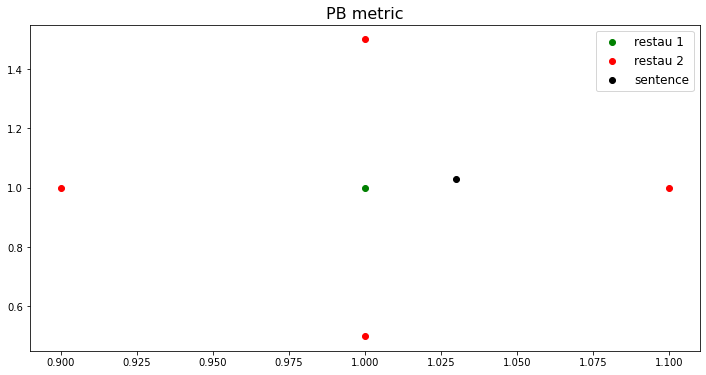

In [54]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize =( 12,6))
plt.scatter(1,1, c = 'g', label = 'restau 1')
plt.scatter([1.1,.9,1,1],[1,1,.5,1.5], c='r', label = 'restau 2')
plt.scatter(1.03,1.03, c='black', label = 'sentence')
plt.title('PB metric', fontdict= {'fontsize' : 16})
plt.legend(fontsize = 12);

In [1]:
### restau 1
restau_1_sim = .8
restau_1_ratio = 1/1
restau_1_metrics = .8

### restau 2
restau_2_sim = np.mean([.76,.7,.65,.71]) #=0.705
restau_2_ratio = 4/4
restau_2_metrics = .705


NameError: name 'np' is not defined

## Try to solve

### ponderation by review_filtered

In [68]:
df.groupby('alias').count().sort_values('sim_s', ascending=False)['date'][:20]

alias
pizza-julia-paris                     79
firmine-paris                         79
gambino-paris-2                       40
pizzeria-babalou-paris                37
pizza-pino-paris-8                    37
pizzeria-popolare-paris-2             36
hank-paris-5                          33
ober-mamma-paris                      30
la-briciola-paris                     28
pizza-vesuvio-paris-8                 26
mokus-l-ecureuil-paris                26
gusto-italia-paris-2                  25
grazie-paris                          24
east-mamma-paris-5                    23
cafe-di-roma-paris                    23
l-as-du-fallafel-paris                22
pizza-iolanda-paris                   21
le-potager-du-père-thierry-paris-2    21
pink-mamma-paris                      19
carmine-café-paris-3                  19
Name: date, dtype: int64

In [ ]:
rest

### create accurate score